# FIND IT 2021 - Tim AMYLIE

## A. Importing

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, AdaBoostRegressor
from sklearn.metrics import classification_report as report
from xgboost import XGBClassifier, plot_importance, XGBRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error as mse
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, cross_val_score, RepeatedKFold, cross_val_predict, StratifiedKFold
import tqdm
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans

from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

import warnings
warnings.filterwarnings("ignore")
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

In [22]:
pd.set_option('display.max_columns',None)

## B. Preprocessing

### Data Input

In [65]:
# Berikut adalah code yang digunakan untuk membaca Dataset Train & Test

# Note: Apabila test ingin diganti oleh panitia untuk melakukan prediksi terhadap "Private-Test Set", dapat diubah pada code
# di bawah ini, yakni pada variabel "test"

train = pd.read_csv('public-train.csv', delimiter='|')
test = pd.read_csv('public-test.csv', delimiter='|')

### Main Preprocessing Pipeline

In [66]:
train.drop_duplicates(inplace=True)

def word_counter(s):
    if pd.isna(s):
        return np.nan
    else:
        res = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~—]', '', s)
        return len(res.strip().split(' '))
    
train['word_count'] = train['description'].map(lambda x: word_counter(x))
test['word_count'] = test['description'].map(lambda x: word_counter(x))


train_labeled = train.loc[~train['price'].isna(),:].copy()
train_unlabeled = train.loc[train['price'].isna(),:].copy()

test_price = test['price']

coldrop = ['bookedition', 'reading_age', 'published_date', 'lexile_measure', 'grade_level', 'description','price']
train_labeled.drop(columns=coldrop, inplace=True)
train_unlabeled.drop(columns=coldrop, inplace=True)
test.drop(columns=coldrop, inplace=True)

numcol = train_labeled.select_dtypes(exclude='object').columns.tolist()

genre_weight = []
for i in range(10):
    a = f'genre_{i}_weight'
    genre_weight.append(a)

for col in genre_weight:
    numcol.remove(col)

med = SimpleImputer(strategy='median')
train_labeled[numcol] = med.fit_transform(train_labeled[numcol])
train_unlabeled[numcol] = med.transform(train_unlabeled[numcol])

train_all = pd.concat([train_labeled, train_unlabeled], axis=0)
med.fit(train_all[numcol])
test[numcol] = med.transform(test[numcol])


# ---
# Step 1: Normal Variables
cats_nongenre = ['author_id', 'bookformat', 'publisher_id']

# For loop
for cat in cats_nongenre:
    cat_list = list(set(train_all[cat].unique().tolist())) #PERLU DIUBAH JADI TRAIN, CONCAT DLU UNLABELED+LABELED
    labels = [i for i in range(0, len(cat_list))]
    cat_dict = dict(zip(cat_list, labels))
    train_labeled[cat] = train_labeled[cat].apply(lambda x: cat_dict[x] if x in cat_dict else -1) 
    train_unlabeled[cat] = train_unlabeled[cat].apply(lambda x: cat_dict[x] if x in cat_dict else -1)
    test[cat] = test[cat].apply(lambda x: cat_dict[x] if x in cat_dict else -1)

    
# ---
# Step 2: Genres
cats_genre = ['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9']

# For loop, Create Unique Dictionary
genre_list = []
for cat in cats_genre:
    genre_list.extend(train_all[cat].unique().tolist())
    
# NaN is not a category, so we omit it by doing so.
genre_list = sorted(list(set(genre_list))[1:])
labels = [i for i in range(0,len(genre_list))]
genre_dict = dict(zip(genre_list, labels))

# Next, we map it to the columns
for cat in cats_genre:
    train_labeled[cat] = train_labeled[cat].apply(lambda x: genre_dict[x] if x in genre_dict else np.nan)
    train_unlabeled[cat] = train_unlabeled[cat].apply(lambda x: genre_dict[x] if x in genre_dict else np.nan)
    test[cat] = test[cat].apply(lambda x: genre_dict[x] if x in genre_dict else np.nan)
# ---

for col in cats_genre:
    train_labeled[col] = train_labeled[col].fillna(-1)
    train_unlabeled[col] = train_unlabeled[col].fillna(-1)
    test[col] = test[col].fillna(-1)

train_labeled[cats_genre] = train_labeled[cats_genre].astype('int')
train_unlabeled[cats_genre] = train_unlabeled[cats_genre].astype('int')  
test[cats_genre] = test[cats_genre].astype('int')  

# Perimeter feature
train_labeled['perimeter'] = (train_labeled['dimension_0'] * 4 + train_labeled['dimension_1'] * 4 + train_labeled['dimension_2'] * 4)
train_unlabeled['perimeter'] = (train_unlabeled['dimension_0'] * 4 + train_unlabeled['dimension_1'] * 4 + train_unlabeled['dimension_2'] * 4)
test['perimeter'] = (test['dimension_0'] * 4 + test['dimension_1'] * 4 + test['dimension_2'] * 4)

# Reimpute price
train_labeled['price'] = train.loc[~train['price'].isna(),:].price.copy()

In [8]:
test['bookformat'].value_counts()

Hardcover                357
Paperback                 90
Kindle Edition            44
Mass Market Paperback      6
Comics                     2
Spiral-bound               1
Name: bookformat, dtype: int64

In [9]:
train['bookformat'].value_counts()

Hardcover                2524
Paperback                 714
Kindle Edition            201
Mass Market Paperback      43
ebook                      42
Board Book                  3
Nook                        3
paperback                   2
Unknown Binding             1
Spiral-bound                1
Library Binding             1
Comics                      1
Trade Paperback             1
Name: bookformat, dtype: int64

<AxesSubplot:xlabel='bookformat', ylabel='price'>

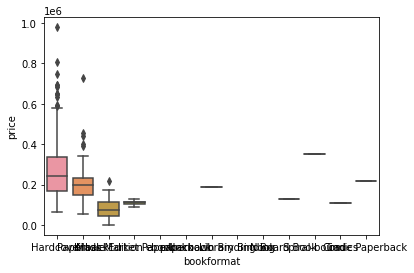

In [10]:
sns.boxplot(x='bookformat', y='price',data=train, )

---

## C. Modelling

In [32]:
x = train_labeled.drop(columns=['price'])
x = x.drop(columns=genre_weight)
y = train_labeled['price']
# labeled = pd.concat([x,y], axis=1)

In [40]:
catcol = cats_nongenre + cats_genre

catb = CatBoostRegressor(cat_features=catcol,
                       verbose=0,random_state=69)
catb.fit(x,y)
cv = KFold(n_splits=5)
val = cross_val_score(catb, x,y,scoring='neg_root_mean_squared_error', cv=cv)
print(np.mean(val*-1))

121348.28168008263


In [16]:
120800

120800

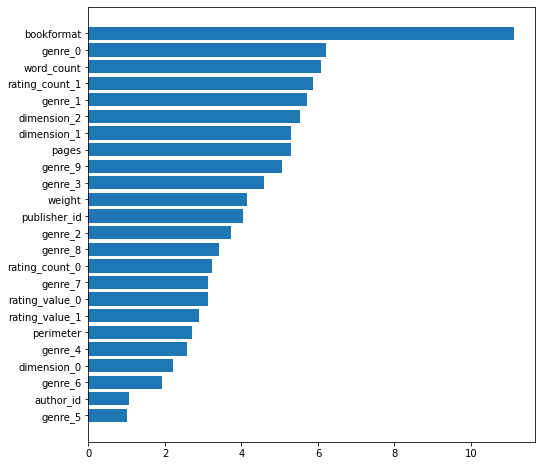

In [17]:
fi = pd.DataFrame()
fi['col'] = x.columns.tolist()
fi['FI'] = catb.get_feature_importance()
fi.sort_values(by=['FI'], inplace=True)

fig, ax = plt.subplots(figsize=(8,8))
ax.barh(fi['col'],fi['FI'])

name = 'FI labeled.svg'
fig.savefig(name, format='svg', bbox_inches='tight', dpi=1200)

In [34]:
xgb = XGBRegressor(n_estimators=300, objective='reg:squarederror', random_state=69)
xgb.fit(x, y)
cv = KFold(n_splits=5)
val = cross_val_score(xgb, x,y,scoring='neg_root_mean_squared_error', cv=cv)
print(np.mean(val*-1))

127594.03311827555


In [41]:
rf = RandomForestRegressor(random_state=69)
rf.fit(x,y)
cv = KFold(n_splits=5)
val = cross_val_score(rf, x,y,scoring='neg_root_mean_squared_error', cv=cv)
print(np.mean(val*-1))

120823.95773067654


In [36]:
lgbm = LGBMRegressor(n_estimators=300, random_state=69)
lgbm.fit(x,y)
cv = KFold(n_splits=5)
val = cross_val_score(lgbm, x,y,scoring='neg_root_mean_squared_error', cv=cv)
print(np.mean(val*-1))

125109.45702048813


In [37]:
ada = AdaBoostRegressor(n_estimators=300, random_state=69)
ada.fit(x,y)
cv = KFold(n_splits=5)
val = cross_val_score(ada, x,y,scoring='neg_root_mean_squared_error', cv=cv)
print(np.mean(val*-1))

130850.37926823692


## D. Hyperparameter Tuning

In [62]:
# CatBoost
space = {
    "n_estimators": hp.quniform("n_estimators",300,1200,50),
    "max_depth": hp.quniform("max_depth", 4, 15,1),
    "learning_rate": hp.uniform("learning_rate", 0.01,0.1),
    'colsample_bylevel': hp.quniform('colsample_bylevel', 0.3, 0.8, 0.1)
}
catcol = cats_nongenre.extend(cats_genre)
def hyperparameter_tuning(params):
    catb = CatBoostRegressor(cat_features=catcol,random_state=69, verbose=0)
    cv = KFold(n_splits=5)
    val = cross_val_score(catb, x,y,scoring='neg_root_mean_squared_error', cv=cv).mean()
    return {"loss": -val, "status": STATUS_OK}

# Initialize trials object
trials = Trials()

best_cat = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best_cat))

100%|██████████████████████████████████████████████| 100/100 [18:37<00:00, 11.17s/trial, best loss: 122738.81607307619]
Best: {'colsample_bylevel': 0.4, 'learning_rate': 0.0544620898189349, 'max_depth': 8.0, 'n_estimators': 950.0}


In [57]:
# XGBoost
space = {
    "n_estimators": hp.quniform("n_estimators", 100,1000,25),
    "max_depth": hp.quniform("max_depth", 1, 15,1),
    "eta": hp.uniform("eta", 0.01,0.1),
    "subsample": hp.uniform("subsample", 0,1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0,1)
}

def hyperparameter_tuning(params):
    xgb = XGBRegressor(objective='reg:squarederror', random_state=69)
    cv = KFold(n_splits=5)
    val = cross_val_score(xgb, x,y,scoring='neg_root_mean_squared_error', cv=cv).mean()
    return {"loss": -val, "status": STATUS_OK}

# Initialize trials object
trials = Trials()

best_xgb = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best_xgb))

100%|██████████████████████████████████████████████| 100/100 [00:51<00:00,  1.92trial/s, best loss: 127584.99822491893]
Best: {'colsample_bytree': 0.0859792300576232, 'eta': 0.06625663512490243, 'max_depth': 6.0, 'n_estimators': 100.0, 'subsample': 0.9283307458216526}


In [58]:
# Random Forest
space = {
    "n_estimators": hp.quniform("n_estimators", 100,1000,25),
    "max_depth": hp.quniform("max_depth", 1, 20,1),
    "max_features": hp.choice('max_features',['auto', 'sqrt']),
    "min_samples_leaf": hp.quniform("min_samples_leaf", 1,15,1)
}

def hyperparameter_tuning(params):
    rf = RandomForestRegressor(random_state=69)
    cv = KFold(n_splits=5)
    val = cross_val_score(rf, x,y,scoring='neg_root_mean_squared_error', cv=cv).mean()
    return {"loss": -val, "status": STATUS_OK}

# Initialize trials object
trials = Trials()

best_rf = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best_rf))

100%|██████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/trial, best loss: 120823.95773067654]
Best: {'max_depth': 13.0, 'max_features': 1, 'min_samples_leaf': 14.0, 'n_estimators': 650.0}


In [59]:
# Light GBM
space = {
    "n_estimators": hp.quniform("n_estimators", 100,1000,25),
    "max_depth": hp.quniform("max_depth", 1, 15,1),
    "learning_rate": hp.uniform("learning_rate", 0.01,0.1),
    "subsample": hp.uniform("subsample", 0,1)
}

def hyperparameter_tuning(params):
    lgbm = LGBMRegressor(objective='root_mean_squared_error', random_state=69)
    cv = KFold(n_splits=5)
    val = cross_val_score(lgbm, x,y,scoring='neg_root_mean_squared_error', cv=cv).mean()
    return {"loss": -val, "status": STATUS_OK}

# Initialize trials object
trials = Trials()

best_lgbm = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best_lgbm))

100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.54trial/s, best loss: 123824.5326069046]
Best: {'learning_rate': 0.09272247434187608, 'max_depth': 3.0, 'n_estimators': 350.0, 'subsample': 0.8985646779081392}


In [60]:
# AdaBoost
space = {
    "n_estimators": hp.quniform("n_estimators", 100,1000,25),
    "learning_rate": hp.uniform("learning_rate", 0.01,0.1),
}

def hyperparameter_tuning(params):
    ada = AdaBoostRegressor(random_state=69)
    cv = KFold(n_splits=5)
    val = cross_val_score(ada, x,y,scoring='neg_root_mean_squared_error', cv=cv).mean()
    return {"loss": -val, "status": STATUS_OK}

# Initialize trials object
trials = Trials()

best_ada = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best_ada))

100%|██████████████████████████████████████████████| 100/100 [00:44<00:00,  2.27trial/s, best loss: 130081.53217109837]
Best: {'learning_rate': 0.061799726030297396, 'n_estimators': 400.0}


In [63]:
# Hypertuned Models Ensembled with Voting Regressor
catcol = cats_nongenre + cats_genre
estimator = [
    ('catboost', CatBoostRegressor(iterations=950, cat_features=catcol,random_state=69, max_depth=8,
                                   learning_rate= 0.0544620898189349, colsample_bylevel= 0.4, verbose=0)),
    ('xgb', XGBRegressor(n_estimators=400, eta= 0.0905523309944472,colsample_bytree= 0.0859792300576232,
                          max_depth= 9, subsample= 0.03074811769423491, objective='reg:squarederror', random_state=69)),
    ('rf', RandomForestRegressor(n_estimators=650, max_depth=13,max_features= 'auto',
                                 min_samples_leaf=14, random_state=69)),
    ('lgbm', LGBMRegressor(objective='root_mean_squared_error', n_estimators=350, learning_rate=0.09272247434187608,
                           subsample= 0.8985646779081392,
                           max_depth=3, random_state=69)),
    ('ada', AdaBoostRegressor(n_estimators=400, learning_rate=0.061799726030297396, random_state=69))
]
vote = VotingRegressor(estimators=estimator)
vote.fit(x,y)
cv = KFold(n_splits=5)
val = cross_val_score(vote, x,y,scoring='neg_root_mean_squared_error', cv=cv)
print(np.mean(val*-1))

120970.86790226554


In [22]:
# Hypertuned Models Ensembled with Voting Regressor
catcol = cats_nongenre + cats_genre
estimator = [
    ('catboost', CatBoostRegressor(iterations=100, cat_features=catcol,random_state=69, depth=8,
                                   learning_rate= 0.09828695333835749, verbose=0)),
    ('xgb', XGBRegressor(n_estimators=100, eta= 0.06625663512490243,colsample_bytree= 0.40649044167540616,
                          max_depth= 6, subsample= 0.928330745821652, objective='reg:squarederror', random_state=69)),
    ('rf', RandomForestRegressor(n_estimators=300, max_depth=16,max_features= 'auto',
                                 min_samples_leaf=11, random_state=69)),
    ('lgbm', LGBMRegressor(objective='root_mean_squared_error', n_estimators=100, learning_rate=0.047426394631992275, subsample= 0.2144640497130379,
                           max_depth=3, random_state=69)),
    ('ada', AdaBoostRegressor(n_estimators=400, learning_rate=0.08617627226458403, random_state=69))
]
vote = VotingRegressor(estimators=estimator)
vote.fit(x,y)
cv = KFold(n_splits=5)
val = cross_val_score(vote, x,y,scoring='neg_root_mean_squared_error', cv=cv)
print(np.mean(val*-1))

121508.91564616436


## E. Input Train ALL

In [67]:
train_unlabeled.drop(columns=genre_weight, inplace=True)
train_unlabeled['price'] = vote.predict(train_unlabeled) 

train_all = pd.concat([train_labeled.drop(columns=genre_weight), train_unlabeled], axis=0)
# train_all = pd.read_csv('train_all.csv')

# # FE of Perimeter
# train_all['perimeter'] = (train_all['dimension_0'] * 4 + train_all['dimension_1'] * 4 + train_all['dimension_2'] * 4)
# test['perimeter'] = (test['dimension_0'] * 4 + test['dimension_1'] * 4 + test['dimension_2'] * 4)

train_all.to_csv('train_all_2.csv', index=False)

train_all = pd.read_csv('train_all_2.csv')

train_all_x = train_all.drop(columns=['price'])
train_all_y = train_all['price']

In [69]:
catcol = cats_nongenre + cats_genre

catb = CatBoostRegressor(cat_features=catcol,
                       verbose=0)
catb.fit(train_all_x,train_all_y)
pred = catb.predict(test_x)
print('RMSE result for Test Set : ')
mse(test_y, pred, squared=False)

RMSE result for Test Set : 


169924.472995557

In [16]:
120800

120800

<BarContainer object of 24 artists>

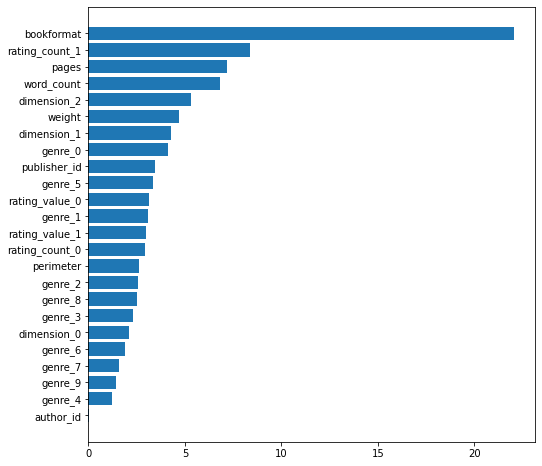

In [48]:
fi = pd.DataFrame()
fi['col'] = x.columns.tolist()
fi['FI'] = catb.get_feature_importance()
fi.sort_values(by=['FI'], inplace=True)

fig, ax = plt.subplots(figsize=(8,8))
ax.barh(fi['col'],fi['FI'])

# name = 'FI labeled.svg'
# fig.savefig(name, format='svg', bbox_inches='tight', dpi=1200)

In [70]:
xgb = XGBRegressor(n_estimators=300, objective='reg:squarederror', random_state=69)
xgb.fit(train_all_x,train_all_y)
pred = xgb.predict(test_x)
print('RMSE result for Test Set : ')
mse(test_y, pred, squared=False)

RMSE result for Test Set : 


174175.47391940316

In [71]:
rf = RandomForestRegressor(n_estimators=300, max_depth=15, random_state=69)
rf.fit(train_all_x,train_all_y)
pred = rf.predict(test_x)
print('RMSE result for Test Set : ')
mse(test_y, pred, squared=False)

RMSE result for Test Set : 


172904.02864261623

In [72]:
lgbm = LGBMRegressor(n_estimators=300, random_state=69)
lgbm.fit(train_all_x,train_all_y)
pred = lgbm.predict(test_x)
print('RMSE result for Test Set : ')
mse(test_y, pred, squared=False)

RMSE result for Test Set : 


176622.71255052753

In [73]:
ada = AdaBoostRegressor(n_estimators=300, random_state=69)
ada.fit(train_all_x,train_all_y)
pred = ada.predict(test_x)
print('RMSE result for Test Set : ')
mse(test_y, pred, squared=False)

RMSE result for Test Set : 


179796.82372095843

## F. Hypertuning Model for Train_all

In [75]:
test_x = test.drop(columns=genre_weight)
test_y = test_price

In [77]:
# CatBoost
space = {
    "n_estimators": hp.quniform("n_estimators",300,1200,50),
    "max_depth": hp.quniform("max_depth", 4, 15,1),
    "learning_rate": hp.uniform("learning_rate", 0.01,0.1),
    'colsample_bylevel': hp.quniform('colsample_bylevel', 0.3, 0.8, 0.1)
}
catcol = cats_nongenre.extend(cats_genre)
def hyperparameter_tuning(params):
    catb = CatBoostRegressor(cat_features=catcol,random_state=69, verbose=0)
    catb.fit(train_all_x, train_all_y)
    pred = catb.predict(test_x)
    val = mse(test_y, pred, squared=False)
    return {"loss": val, "status": STATUS_OK}

# Initialize trials object
trials = Trials()

best_cat = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best_cat))

100%|██████████████████████████████████████████████| 100/100 [05:35<00:00,  3.36s/trial, best loss: 170759.64820121185]
Best: {'colsample_bylevel': 0.6000000000000001, 'learning_rate': 0.011065727010349745, 'max_depth': 6.0, 'n_estimators': 750.0}


In [78]:
# XGBoost
space = {
    "n_estimators": hp.quniform("n_estimators", 100,1000,25),
    "max_depth": hp.quniform("max_depth", 1, 15,1),
    "eta": hp.uniform("eta", 0.01,0.1),
    "subsample": hp.uniform("subsample", 0,1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0,1)
}

def hyperparameter_tuning(params):
    xgb = XGBRegressor(objective='reg:squarederror', random_state=69)
    xgb.fit(train_all_x, train_all_y)
    pred = xgb.predict(test_x)
    val = mse(test_y, pred, squared=False)
    return {"loss": val, "status": STATUS_OK}

# Initialize trials object
trials = Trials()

best_xgb = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best_xgb))

100%|██████████████████████████████████████████████| 100/100 [00:30<00:00,  3.33trial/s, best loss: 174152.72568813906]
Best: {'colsample_bytree': 0.881806735425383, 'eta': 0.08320560857685327, 'max_depth': 4.0, 'n_estimators': 550.0, 'subsample': 0.4858511868988319}


In [82]:
# Random Forest
space = {
    "n_estimators": hp.quniform("n_estimators", 100,1000,25),
    "max_depth": hp.quniform("max_depth", 2, 20,1),
    "max_features": hp.choice('max_features',['auto', 'sqrt']),
    "min_samples_leaf": hp.quniform("min_samples_leaf", 1,15,1)
}

def hyperparameter_tuning(params):
    rf = RandomForestRegressor(random_state=69)
    rf.fit(train_all_x, train_all_y)
    pred = rf.predict(test_x)
    val = mse(test_y, pred, squared=False)
    return {"loss": val, "status": STATUS_OK}

# Initialize trials object
trials = Trials()

best_rf = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best_rf))

100%|██████████████████████████████████████████████| 100/100 [04:17<00:00,  2.58s/trial, best loss: 174099.20526059266]
Best: {'max_depth': 3.0, 'max_features': 0, 'min_samples_leaf': 2.0, 'n_estimators': 300.0}


In [80]:
# Light GBM
space = {
    "n_estimators": hp.quniform("n_estimators", 100,1000,25),
    "max_depth": hp.quniform("max_depth", 1, 15,1),
    "learning_rate": hp.uniform("learning_rate", 0.01,0.1),
    "subsample": hp.uniform("subsample", 0,1)
}

def hyperparameter_tuning(params):
    lgbm = LGBMRegressor(objective='root_mean_squared_error', random_state=69)
    lgbm.fit(train_all_x, train_all_y)
    pred = lgbm.predict(test_x)
    val = mse(test_y, pred, squared=False)
    return {"loss": val, "status": STATUS_OK}

# Initialize trials object
trials = Trials()

best_lgbm = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best_lgbm))

100%|██████████████████████████████████████████████| 100/100 [00:11<00:00,  8.34trial/s, best loss: 175338.57646777076]
Best: {'learning_rate': 0.054436443139513395, 'max_depth': 11.0, 'n_estimators': 450.0, 'subsample': 0.26624550206336195}


In [81]:
# AdaBoost
space = {
    "n_estimators": hp.quniform("n_estimators", 100,1000,25),
    "learning_rate": hp.uniform("learning_rate", 0.01,0.1),
}

def hyperparameter_tuning(params):
    ada = AdaBoostRegressor(random_state=69)
    ada.fit(train_all_x, train_all_y)
    pred = ada.predict(test_x)
    val = mse(test_y, pred, squared=False)
    return {"loss": val, "status": STATUS_OK}

# Initialize trials object
trials = Trials()

best_ada = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best_ada))

100%|███████████████████████████████████████████████| 100/100 [00:32<00:00,  3.11trial/s, best loss: 179074.4907830813]
Best: {'learning_rate': 0.06252173426169733, 'n_estimators': 400.0}


## G. Voting Regressor for Train ALL

In [46]:
# Hypetuned Models Ensembled with Voting Regressor for Train_all
estimator = [
    ('catboost', CatBoostRegressor(iterations=300, cat_features=catcol,random_state=69, depth=11,
                                   learning_rate= 0.05990044272853458, colsample_bylevel= 0.6,verbose=0)),
    ('xgb', XGBRegressor(n_estimators=500, eta= 0.04638072852567231,colsample_bytree= 0.34666747042517165,
                          max_depth= 15, subsample= 0.1822452768121341, objective='reg:squarederror', random_state=69)),
    ('rf', RandomForestRegressor(n_estimators=500, max_depth=9,max_features= 'auto',
                                 min_samples_leaf=14, random_state=69)),
    ('lgbm', LGBMRegressor(objective='root_mean_squared_error', n_estimators=100, learning_rate= 0.055235847205381654, subsample= 0.19837565816972547,
                           max_depth=14, random_state=69)),
    ('ada', AdaBoostRegressor(n_estimators=100, learning_rate=0.0848671249579081, random_state=69))
]
newvote = VotingRegressor(estimators=estimator)
newvote.fit(train_all_x,train_all_y)
pred = newvote.predict(test_x)
print('RMSE result for Test Set : ')
mse(test_y, pred, squared=False)

RMSE result for Test Set : 


168876.36591621497

In [ ]:
pred.to_csv('public test set prediction.csv', index=False)